# Can we predict the churn/retention rate of Telco customers?

## Motivation

**This notebook goes through exploratory data analysis and predictive classification modeling of the Kaggle Telco Customer Churn dataset with Python.**

The primary purpose of this kernel is to showcase my skills in those two practices for a classification business problem. 

## Content

Each row/instance/observation represents a customer. 

Each column represents a feature/customer’s attribute that may or may not have an influence in the prediction of customer churn/retention.

* [1. Importing Library](#importing_library)
* [2. Data Overview](#data_overview)
* [3. Feature Engineering](#feature_engineering)
* [4. Exploratory Data Analysis](#eda)
* [5. Models](#models)
* [6. Model Accuracy Result](#accuracy)
* [7. Conclusion](#conclusion)


# 1. Importing Library <a class="anchor" id="importing_library"></a>

Data Visualization libraries have been imported. Machine Learning algorithms from sklearn, yellowbrick, and etc. will be imported when creating the models.

In [1]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt#visualization
import seaborn as sns#visualization
%matplotlib inline

from PIL import  Image

import itertools
import warnings
warnings.filterwarnings("ignore")

import io
import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff #visualization
from plotly.subplots import make_subplots #visualization

pd.set_option('display.max_columns', 100)

# 2. Data Overview <a class="anchor" id="data_overview"></a>

In [2]:
df = pd.read_csv("../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
print(df.shape)
summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
summary['Missing'] = df.isnull().sum().values    
summary['Uniques'] = df.nunique().values
summary

(7043, 21)


,dtypes,Missing,Uniques
customerID,object,0,7043
gender,object,0,2
SeniorCitizen,int64,0,2
Partner,object,0,2
Dependents,object,0,2
tenure,int64,0,73
PhoneService,object,0,2
MultipleLines,object,0,3
InternetService,object,0,3
OnlineSecurity,object,0,3


1. No null values.
2. Multiple categorical features.

In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


# 3. Feature Engineering <a class="anchor" id="feature_engineering"></a>

Although there are no null values, there may be empty strings or white spaces that serve as null values. Therefore, check to see if there are any features containing the two placeholders.

In [6]:
for column in df.columns:
    if '' in df[column].values or ' ' in df[column].values:
        print(column)

TotalCharges


In [7]:
df['TotalCharges'] = df['TotalCharges'].replace('',np.nan)
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)

In [8]:
totalinstances = df.shape[0]
totalnull = df['TotalCharges'].isnull().sum()
print(round((totalnull/totalinstances*100),2),'%')

0.16 %


The total null values constitute only ~0.16% of the total data. Therefore, dropping these instances will not have any significant effect on the accuracy of the subsequent statistical models. 

In [9]:
df.dropna(axis=0, inplace = True)

Always change the datatype of variables if applicable to optimize speed and memory.

In [10]:
df['TotalCharges'] = df['TotalCharges'].astype('float')

Temporarily replacing the values for exploratory analysis. Will be reverted back to numerical datatype when performing various machine learning models.

In [11]:
df["SeniorCitizen"] = df["SeniorCitizen"].replace({1:"Yes",0:"No"})

In [12]:
for column in df.columns:
    print(column +':','\n',np.unique(df[column])[:5],'\n')

customerID: 
 ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' '0011-IGKFF' '0013-EXCHZ'] 

gender: 
 ['Female' 'Male'] 

SeniorCitizen: 
 ['No' 'Yes'] 

Partner: 
 ['No' 'Yes'] 

Dependents: 
 ['No' 'Yes'] 

tenure: 
 [1 2 3 4 5] 

PhoneService: 
 ['No' 'Yes'] 

MultipleLines: 
 ['No' 'No phone service' 'Yes'] 

InternetService: 
 ['DSL' 'Fiber optic' 'No'] 

OnlineSecurity: 
 ['No' 'No internet service' 'Yes'] 

OnlineBackup: 
 ['No' 'No internet service' 'Yes'] 

DeviceProtection: 
 ['No' 'No internet service' 'Yes'] 

TechSupport: 
 ['No' 'No internet service' 'Yes'] 

StreamingTV: 
 ['No' 'No internet service' 'Yes'] 

StreamingMovies: 
 ['No' 'No internet service' 'Yes'] 

Contract: 
 ['Month-to-month' 'One year' 'Two year'] 

PaperlessBilling: 
 ['No' 'Yes'] 

PaymentMethod: 
 ['Bank transfer (automatic)' 'Credit card (automatic)' 'Electronic check'
 'Mailed check'] 

MonthlyCharges: 
 [18.25 18.4  18.55 18.7  18.75] 

TotalCharges: 
 [18.8  18.85 18.9  19.   19.05] 

Churn: 
 ['No' 'Yes

Replace columns with value "No internet service" to "No" to group and reduce labels. It can be surmised that if there is no internet service, then the customer cannot have access to the features. 

In [13]:
nointernet = []
for column in df.columns:
    if "No internet service" in df[column].unique():
        nointernet.append(column)

for col in nointernet : 
    df[col]  = df[col].replace('No internet service', 'No')

# 4. Exploratory Data Analysis <a class="anchor" id="eda"></a>

## 4.1 Overall Customer Churn Rate

In [14]:
label = list(df['Churn'].unique())
value = df['Churn'].value_counts()
value_percent = list(round(value/df.shape[0],2))

In [15]:
t1 = go.Bar(
    x=label,
    y=value_percent,
    width = [0.5, 0.5],
    marker=dict(
        color=['green', 'blue'])
    )


layout = go.Layout(dict(
    title='Overall Customer Churn Rate',
    plot_bgcolor  = "rgb(243,243,243)",
    paper_bgcolor = "rgb(243,243,243)",
    xaxis = dict(
        gridcolor = 'rgb(255, 255, 255)',
        title = "Churn",
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2
        ),
    yaxis = dict(
        gridcolor = 'rgb(255, 255, 255)',
        title = "Percent",
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2
        ),
    )
)

fig = go.Figure(data=t1, layout=layout)
fig.update_layout(title_x=0.5)
py.iplot(fig)




More customers are retained (0.73%) than churned (0.27%). Proportionally, there are much more customers retained than churned. However, whether the 27% churn rate is acceptable or not depends on the business goals. 

## 4.2 Customer Churn Rate By Categorical Features

In [16]:
# Separating the churn rates for comparison of various categorical features.
churn = df[df['Churn'] == 'Yes']
retention = df[df['Churn'] == 'No']

In [17]:
# Generally, we round up sample sizes when estimating population mean/proportion.

import math

def round_decimals_up(og_list, decimals:int=2):
    """
    Returns rounded up list to a specific number of decimal places.
    """
    
    rounded_list = []
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.ceil(number)

    factor = 10 ** decimals
    
    for number in og_list:
        
        rounded_list.append((math.ceil(number * factor) / factor))
    
    return rounded_list

In [18]:
def barplot_rounded(col):
    
    rounded_churn = round_decimals_up((churn[col].value_counts()/churn.shape[0]),3)
    rounded_retention = round_decimals_up((retention[col].value_counts()/retention.shape[0]),3)
    
    t1 = go.Bar(
        x = list(churn[col].value_counts().keys()),
        y = rounded_churn, 
        name = 'Churn',
        marker_color = 'rgb(55, 83, 109)'
    )
    
    t2 = go.Bar(
        x = list(retention[col].value_counts().keys()),
        y = rounded_retention,
        name = 'Retention',
        marker_color = 'rgb(26, 118, 255)'
    )
    
    data = [t1,t2]
    
    layout = go.Layout(dict(
        title = "Churn Rate by " + col,
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor = "rgb(243,243,243)",
        xaxis = dict(
            gridcolor = 'rgb(255, 255, 255)',
            title = col,
            zerolinewidth=1,
            ticklen=5,
            gridwidth=2
            ),
        yaxis = dict(
            gridcolor = 'rgb(255, 255, 255)',
            title = "Percent",
            zerolinewidth=1,
            ticklen=5,
            gridwidth=2
            ),
        )
    )
    
    fig  = go.Figure(data=data,layout=layout)
    fig.update_layout(title_x=0.5)
    py.iplot(fig)

In [19]:
df.nunique()[df.nunique() <= 4]

gender              2
SeniorCitizen       2
Partner             2
Dependents          2
PhoneService        2
MultipleLines       3
InternetService     3
OnlineSecurity      2
OnlineBackup        2
DeviceProtection    2
TechSupport         2
StreamingTV         2
StreamingMovies     2
Contract            3
PaperlessBilling    2
PaymentMethod       4
Churn               2
dtype: int64

These are all the categorical features that may be can be plotted into the **barplot** function. Churn is excluded as that is our target variable. 

In [20]:
categorical = df.nunique()[df.nunique() <= 4].index[:-1]

In [21]:
for col in categorical:
    barplot_rounded(col)

1. Gender, Multiple Lines, and Phone Service features does not have any signficant differences in Churn Rates between the categories. For example, the churn/retention percentage for Female and Male (gender variable) were 0.5/0.49 and 0.5/0.5, respectively.

2. The rest of the features seems to have noticeable Churn Rate differences.

Note: While these barplots provide a general idea of how each categorical feature individually determine the customer churn rate, we cannot make any conclusion on the systematic function that provides the information on the target variable, since, there are more than one input variables (features). Some variables may be weak in predicting the Churn Rate on their own, but when combined with one or more variables, their influence may be much greater. Various machine learning algorithms are performed to make any predictions or inferences on the relationship between the features and target.

## 4.3 Churn Rate by Numerical Features

In [22]:
tenure = df.groupby('Churn')['tenure'].value_counts().unstack(0)

def tenure_scatter(df):
    
    t1 = go.Scatter(
            x = list(df.index),
            y = df.loc[:,'Yes'],
            mode = 'markers',
            name = 'Churn',
            marker = dict(
                line = dict(
                    color = "black",
                    width = .5),
                color = 'blue',
                opacity = 0.8
               ),
        )

    t2 = go.Scatter(
            x = list(df.index),
            y = df.loc[:,'No'],
            mode = 'markers',
            name = 'Retention',
            marker = dict(
                line = dict(
                    color = "black",
                    width = .5),
                color = 'green',
                opacity = 0.8
               ),
        )

    layout = go.Layout(dict(
        title='Churn based on Tenure',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor = "rgb(243,243,243)",
        xaxis = dict(
            gridcolor = 'rgb(255, 255, 255)',
            title = "Tenure",
            zerolinewidth=1,
            ticklen=5,
            gridwidth=2
            ),
        yaxis = dict(
            gridcolor = 'rgb(255, 255, 255)',
            title = "Churn/Retention",
            zerolinewidth=1,
            ticklen=5,
            gridwidth=2
            ),
        )
    )
    
    data = [t1,t2]

    fig  = go.Figure(data=data,layout=layout)
    fig.update_layout(title_x=0.5)
    py.iplot(fig)

tenure_scatter(tenure)

Generally, retention tends to increase as the the tenure increases while churn gradually decreases as the tenure increases. To get a better understanding of the effect of tenure on churn rates, tenure will be grouped into 6 bins (72 total tenure groups thus 12 months per bin).

In [23]:
def bin_tenure(df) :
    
    if df["tenure"] <= 12 :
        return "Tenure 0-12"
    elif (df["tenure"] > 12) & (df["tenure"] <= 24 ):
        return "Tenure 12-24"
    elif (df["tenure"] > 24) & (df["tenure"] <= 48) :
        return "Tenure 24-48"
    elif (df["tenure"] > 48) & (df["tenure"] <= 60) :
        return "Tenure 48-60"
    elif df["tenure"] > 60 :
        return "Tenure 60+"
    
df["bin_tenure"] = df.apply(lambda df:bin_tenure(df),
                                      axis = 1)

tenure_binned = df.groupby('Churn')['bin_tenure'].value_counts().unstack(0)

tenure_scatter(tenure_binned)

After grouping the tenure into 12 month bins, it is evident that the churn rate decreases the longer the customer stays with the company. Retention rate tends to fluctuate over the 72 months period suggesting that there may be some other factors/influences that are causing the fluctuation or just that there are less instances between 12-24 and 48-60 month periods. 

In [24]:
# Feature engineering for creating scatterplots on Monthly/Total Charges.

df_copy = df.copy()

df_copy.loc[df_copy.Churn=='No','Churn'] = 0 
df_copy.loc[df_copy.Churn=='Yes','Churn'] = 1

df_copy.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,bin_tenure
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,Tenure 0-12
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,Tenure 24-48
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,Tenure 0-12
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,Tenure 24-48
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,Tenure 0-12


In [25]:
print(df_copy['Churn'].dtype)

object


In [26]:
# Change dtype.
df_copy['Churn'] = df_copy['Churn'].astype(int)

In [27]:
df_mc = df_copy.groupby('MonthlyCharges').Churn.mean().reset_index()

In [28]:
def charges_scatter(df,col,title,x_title):
    
    t1 = go.Scatter(
                x = df[col],
                y = df['Churn'],
                mode = 'markers',
                name = 'Churn',
                marker = dict(
                    line = dict(
                        color = "black",
                        width = .5),
                    color = 'red',
                    opacity = 0.8
                   ),
            )

    layout = go.Layout(dict(
        title = title,
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor = "rgb(243,243,243)",
        xaxis = dict(
            gridcolor = 'rgb(255, 255, 255)',
            title = x_title,
            zerolinewidth=1,
            ticklen=5,
            gridwidth=2
            ),
        yaxis = dict(
            gridcolor = 'rgb(255, 255, 255)',
            title = "Churn Rate",
            zerolinewidth=1,
            ticklen=5,
            gridwidth=2
            ),
        )
    )

    data = [t1]

    fig = go.Figure(data=data,layout=layout)
    fig.update_layout(title_x=0.5)
    py.iplot(fig)

charges_scatter(
    df_mc,
    'MonthlyCharges',
    'Churn Rate by Monthly Charges',
    'Monthly Charges'
)


In [29]:
print(df_copy['MonthlyCharges'].dtype)

float64


In [30]:
df_copy['MonthlyCharges'].value_counts().head()

20.05    61
19.85    44
19.90    44
19.95    44
19.65    43
Name: MonthlyCharges, dtype: int64

Significant amount of 0% and 100% churn rate. This is due to the fact that numerous **Monthly Charges** values only have 1 instance. Therefore, the **Monthly Charges** will be rounded and grouped to the nearest whole number to further examine the relationship between **Monthly Charges** and **Churn Rate**. Same for **Total Charges**.

In [31]:
df_copy = df.copy()

df_copy.loc[df_copy.Churn=='No','Churn'] = 0 
df_copy.loc[df_copy.Churn=='Yes','Churn'] = 1

df_copy['Churn'] = df_copy['Churn'].astype(int)
df_copy.MonthlyCharges = df_copy.MonthlyCharges.round()
df_copy.TotalCharges = df_copy.TotalCharges.round()

df_mc = df_copy.groupby('MonthlyCharges').Churn.mean().reset_index()
df_tc = df_copy.groupby('TotalCharges').Churn.mean().reset_index()

charges_scatter(
    df_mc,
    'MonthlyCharges',
    'Churn Rate by Monthly Charges',
    'Monthly Charges'
)

There seems to be no relationship between **Monthly Charges** and **Churn Rate**.

In [32]:
charges_scatter(
    df_tc,
    'TotalCharges',
    'Churn Rate by Total Charges',
    'Total Charges'
)

There seems to be no relationship between **Total Charges** and **Churn Rate**.

In [33]:
# Average monthly charges for each tenure group.
df_num = df.groupby(['Churn','bin_tenure'])[['MonthlyCharges','TotalCharges']].mean().reset_index()

df_num_churn = df_num[df_num.Churn == 'Yes']
df_num_retention = df_num[df_num.Churn == 'No']

In [34]:
t1 = go.Bar(
    x = df_num_churn.bin_tenure,
    y = df_num_churn.MonthlyCharges,
    name = 'Churn',
    marker = dict(
        line = dict(
            width = 1
        )
    ),
    text = 'Churn'
)

t2 = go.Bar(
    x = df_num_retention.bin_tenure,
    y = df_num_retention.MonthlyCharges,
    name = 'Retention',
    marker = dict(
        line = dict(
            width =1
        )
    ),
    text = 'Retention'
)

layout = go.Layout(
    dict(
        title = 'Average Monthly Charge by Tenure',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor = "rgb(243,243,243)",
        xaxis = dict(
            gridcolor = 'rgb(255, 255, 255)',
            title = 'Tenure Group',
            zerolinewidth=1,
            ticklen=5,
            gridwidth=2
            ),
        yaxis = dict(
            gridcolor = 'rgb(255, 255, 255)',
            title = "Average Monthly Charge",
            zerolinewidth=1,
            ticklen=5,
            gridwidth=2
            ),
        )
    )

data = [t1,t2]

fig = go.Figure(data=data, layout=layout)
fig.update_layout(title_x=0.5)
py.iplot(fig)

On average, for all groups, people who churned had higher monthly charge than people who were retained.

In [35]:
t1 = go.Bar(
    x = df_num_churn.bin_tenure,
    y = df_num_churn.TotalCharges,
    name = 'Churn',
    marker = dict(
        line = dict(
            width = 1
        )
    ),
    text = 'Churn'
)

t2 = go.Bar(
    x = df_num_retention.bin_tenure,
    y = df_num_retention.TotalCharges,
    name = 'Retention',
    marker = dict(
        line = dict(
            width =1
        )
    ),
    text = 'Retention'
)

layout = go.Layout(
    dict(
        title = 'Average Total Charge by Tenure',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor = "rgb(243,243,243)",
        xaxis = dict(
            gridcolor = 'rgb(255, 255, 255)',
            title = 'Tenure Group',
            zerolinewidth=1,
            ticklen=5,
            gridwidth=2
            ),
        yaxis = dict(
            gridcolor = 'rgb(255, 255, 255)',
            title = "Average Total Charge",
            zerolinewidth=1,
            ticklen=5,
            gridwidth=2
            ),
        )
    )

data = [t1,t2]

fig = go.Figure(data=data, layout=layout)
fig.update_layout(title_x=0.5)
py.iplot(fig)

On average, for all groups, people who churned had higher total charge than people who were retained.

## 3.2 Label Encoding

In [36]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Encoded dataframe
df_enc = df.copy()
df_enc.drop(columns=["bin_tenure"], inplace=True)
customerid = ['customerID']
target = ["Churn"]

#categorical columns
cat_cols = df_enc.nunique()[df_enc.nunique() < 6].keys().tolist()
cat_cols = [x for x in cat_cols if x not in target]
#numerical columns
num_cols = [x for x in df_enc.columns if x not in cat_cols + target + customerid]
#Binary columns with 2 values
bin_cols = df_enc.nunique()[df_enc.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    df_enc[i] = le.fit_transform(df_enc[i])
    
#Duplicating columns for multi value columns
df_enc = pd.get_dummies(data = df_enc,columns = multi_cols)

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(df_enc[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_unscaled = df_enc.copy()

df_enc = df_enc.drop(columns = num_cols,axis = 1)
df_enc = df_enc.merge(scaled,left_index=True,right_index=True,how = "left").dropna()
df_enc.head(n=3)

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
0,7590-VHVEG,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,-1.280248,-1.161694,-0.994194
1,5575-GNVDE,1,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0.064303,-0.260878,-0.173740
2,3668-QPYBK,1,0,0,0,1,1,1,0,0,0,0,1,1,1,0,0,1,0,0,1,0,0,0,0,0,1,-1.239504,-0.363923,-0.959649


In [37]:
#Check the values for each column for encoding and scaling.
for column in df_enc.columns:
    print(column +':','\n',np.unique(df_enc[column])[:5],'\n')

customerID: 
 ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' '0011-IGKFF' '0013-EXCHZ'] 

gender: 
 [0 1] 

SeniorCitizen: 
 [0 1] 

Partner: 
 [0 1] 

Dependents: 
 [0 1] 

PhoneService: 
 [0 1] 

OnlineSecurity: 
 [0 1] 

OnlineBackup: 
 [0 1] 

DeviceProtection: 
 [0 1] 

TechSupport: 
 [0 1] 

StreamingTV: 
 [0 1] 

StreamingMovies: 
 [0 1] 

PaperlessBilling: 
 [0 1] 

Churn: 
 [0 1] 

MultipleLines_No: 
 [0 1] 

MultipleLines_No phone service: 
 [0 1] 

MultipleLines_Yes: 
 [0 1] 

InternetService_DSL: 
 [0 1] 

InternetService_Fiber optic: 
 [0 1] 

InternetService_No: 
 [0 1] 

Contract_Month-to-month: 
 [0 1] 

Contract_One year: 
 [0 1] 

Contract_Two year: 
 [0 1] 

PaymentMethod_Bank transfer (automatic): 
 [0 1] 

PaymentMethod_Credit card (automatic): 
 [0 1] 

PaymentMethod_Electronic check: 
 [0 1] 

PaymentMethod_Mailed check: 
 [0 1] 

tenure: 
 [-1.28024804 -1.23950408 -1.19876011 -1.15801615 -1.11727219] 

MonthlyCharges: 
 [-1.54728308 -1.54229701 -1.53731095 -1.53232488 

In [38]:
df_enc.describe()[num_cols]

,tenure,MonthlyCharges,TotalCharges
count,7021.000000,7021.000000,7021.000000
mean,0.000538,-0.000271,0.000450
std,1.000141,0.999997,1.000279
min,-1.280248,-1.547283,-0.999069
25%,-0.954296,-0.970561,-0.830227
50%,-0.139417,0.184544,-0.390473
75%,0.919926,0.832733,0.667141
max,1.612573,1.793381,2.824261


# 5. Models <a class="anchor" id="models"></a>

## 5.1 Synthetic Minority Oversampling Technique (SMOTE)

Before creating various classification models, the data distribution should be considered, since, machine learning algorithms do not consider class distribution. More specifically, Decision Trees and Logistic Regression tend to have bias towards the majority class thus leading to potential misclassification of the minority class. 

SMOTE aims to balance class distribution by randomly increasing minority class examples by replicating them (NOT duplicating). The algorithm takes samples of the feature space for each target class and its nearest neighbors, and generates new examples that combine features of the target case with features of its neighbors. 

In [39]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = df_enc.drop(columns=['customerID','Churn'],axis=1)
y = df_enc.Churn

os = SMOTE(random_state=42)

sm_X_train, sm_X_test, sm_y_train, sm_y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
sm_X,sm_y = os.fit_sample(sm_X_train,sm_y_train)

# Overwriting as all classification models will use smoted data.
X = pd.DataFrame(data = sm_X,columns=sm_X_train.columns)
y = pd.DataFrame(data = sm_y,columns=['Churn'])

y.Churn.value_counts()

1    3832
0    3832
Name: Churn, dtype: int64

After SMOTE is performed, the number of churned and retained customers are equivalent.

## 5.2 Logistic Regression

There are 2 outcomes for churn thus is considered binary classification. All the predictor variables dtypes have been converted to numerical (either int or float) and label encoded. 

In [40]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ClassificationReport, DiscriminationThreshold
from yellowbrick.model_selection import FeatureImportances

Accuracy Score :  0.8082608695652174 

Area under curve :  0.8087459464691931 



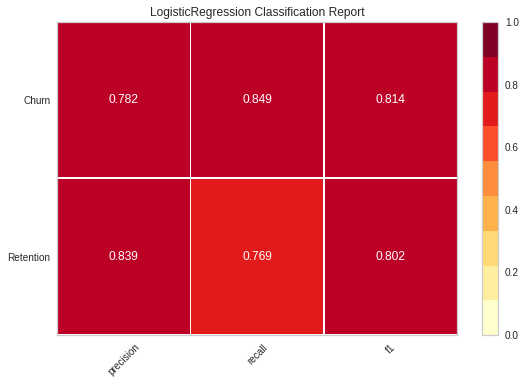

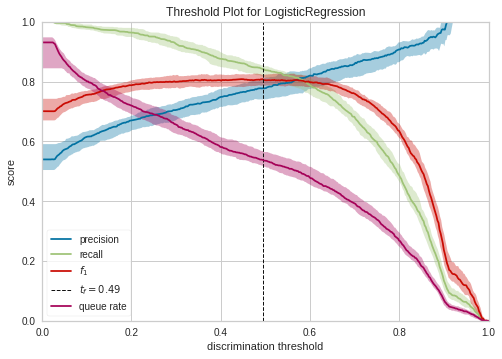

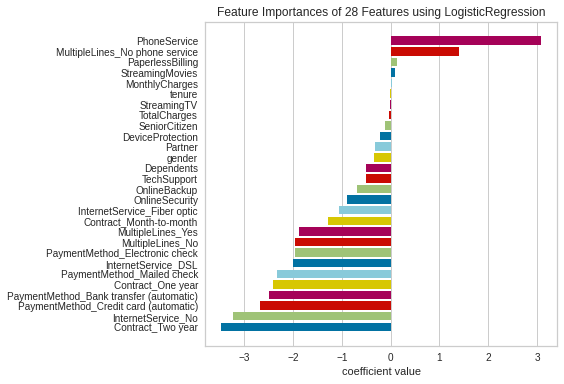

In [41]:
# X = df_enc.drop(columns=['customerID','Churn'],axis=1)
# y = df_enc.Churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3 ,random_state = 42)

log_reg = LogisticRegression(
    C=1,
    fit_intercept=True,
    penalty='l2',
    solver='liblinear'
)


def performance(model, title_text, importance=False):
    model.fit(X_train,y_train)

    prediction = model.predict(X_test)
    probability = model.predict_proba(X_test)

    auc = roc_auc_score(y_test,prediction)

    fpr,tpr,thresholds = roc_curve(y_test,probability[:,1])
    
    accuracy = accuracy_score(y_test,prediction)
    print ("Accuracy Score : ", accuracy,'\n')
    print ("Area under curve : ", auc, '\n')

    report = ClassificationReport(model, classes=['Retention','Churn'])

    report.score(X_test, y_test)
    c = report.poof()

    conf_matrix = confusion_matrix(y_test, prediction)

    t1 = go.Heatmap(
        z = conf_matrix ,
        x = ["Not churn","Churn"],
        y = ["Not churn","Churn"],
        showscale  = True,
        colorscale = "Portland",
        name = "Matrix"
    )

    t2 = go.Scatter(
        x=fpr, 
        y=tpr, 
        mode='lines', 
        line=dict(
            color='darkorange',
            width=2
        ),
        name= auc
    )

    t3 = go.Scatter(
        x=[0, 1], 
        y=[0, 1], 
        mode='lines', 
        line=dict(
            color='navy',
            width=2,
            dash='dash'
        ),
        showlegend=False
    )

    fig = make_subplots(
        rows=2, 
        cols=1, 
        subplot_titles=(
            'Confusion Matrix',
            'Receiver Operating Characteristic'
        )
    )
    fig.append_trace(t1,1,1)
    fig.append_trace(t2,2,1)
    fig.append_trace(t3,2,1)
    fig.update_layout(
        height=700, 
        width=600,
        plot_bgcolor = 'lightgrey',
        paper_bgcolor = 'lightgrey',
        title_text=title_text,
        title_x=0.5,
        showlegend=False,
    )

    fig.update_xaxes(
        range=[-0.05,1.1],
        title="False Positive Rate",
        row=2, col=1
    )
    fig.update_yaxes(
        range=[-0.05,1.1],
        title="True Positive Rate",
        row=2, col=1
    )

    annot = list(fig.layout.annotations)
    annot[0].y = 1.02
    annot[1].y = 0.4
    fig.layout.annotations = annot

    py.iplot(fig)

    # Fit and show the discrimination threshold
    visualizer = DiscriminationThreshold(model)
    visualizer.fit(X_train,y_train)
    v = visualizer.poof()
    
    if importance == False:
        pass
    else:
        feature_importance = FeatureImportances(model, relative=False)

        # Fit and show the feature importances
        feature_importance.fit(X_train,y_train)
        f = feature_importance.poof()
    
    return accuracy

log = performance(
    log_reg, 
    title_text="Logistic Regression Performance",
    importance=True)

Both the accuracy score and the area under curve for the logistic regression is approximately 0.81. This means that the model has 81% chance of classifying the churn rates correctly or capability of distinguishing between classes. 

Note on Precision, Recall, and F1 score:

Recall = a metric which measures a models ability to find all the relevant cases in a dataset.

Precision = a metric which measures a models ability to correctly identify only relevant instances.

F1 score = a weighted average of precision and recall where the metric will fall between 0 and 1, with a higher value being better.

The classification report shows an average precision value of 0.81 meaning when the model predicts the churn or retention of the customers, it is actually correct 81% of the time. Therefore, there is much less false positives for both Churn and Retention. Based on the average recall value of 0.81, the model predicts 81% of actual churn/retention out of all churn/retention. Therefore, there are much less amount of false negatives.

The Discrimination Threshold algorithm is tuned to look for the optimal F1 score, which is annotated as a threshold of 0.45. Therefore, the probability or score at which the positive class is chosen over the negative class is at 0.45.

Note on Linear Models:
Generalized linear models compute a predicted independent variable via the linear combination of an array of coefficients with an array of dependent variables. GLMs are fit by modifying the coefficients so as to minimize error and regularization techniques specify how the model modifies coefficients in relation to each other. Therefore, larger coefficients are necessarily “more informative” because they contribute a greater weight to the final prediction in most cases.

However, how "important" a feature is only makes sense in the context of a specific model being used, and not the real world. For example, Logistic Regression and Random Forests are two completely different methods that make use of the features (in conjunction) differently to maximise predictive power. Therefore, a different set of features offer the most predictive power for each model no matter how counter intuitive the set of features may appear.

Based on the Logistic Regression, Phone Service, Contract_Two year, and InternetService_No have a strong relationship with the Churn Rate.

## 5.3 Recursive Feature Elimination

Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [42]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

rfe = RFE(log_reg)
rfe = rfe.fit(X_train,y_train.values.ravel())

print(rfe.support_)
print()
print(rfe.ranking_)

[False False False False  True False False False False False False False
  True  True  True  True  True  True  True  True  True  True  True  True
  True False False False]

[ 6 10  7  4  1  2  3  8  5 14 11  9  1  1  1  1  1  1  1  1  1  1  1  1
  1 15 13 12]


In [43]:
df_rfe = pd.DataFrame({
    "rfe_support":rfe.support_,
    "columns":X.columns,
    "ranking":rfe.ranking_
})

rfe_cols = df_rfe[df_rfe["rfe_support"] == True]["columns"].tolist()
rfe_cols

['PhoneService',
 'MultipleLines_No',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'InternetService_No',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'PaymentMethod_Bank transfer (automatic)',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check']

Accuracy Score :  0.7943478260869565 

Area under curve :  0.794979066840908 



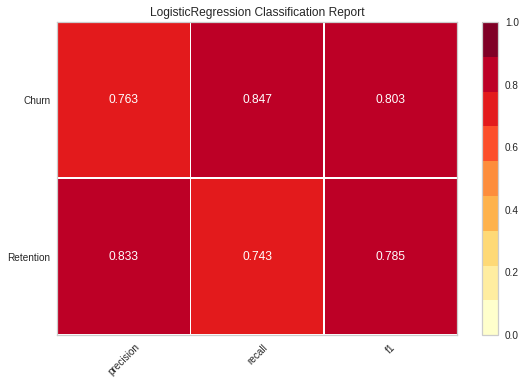

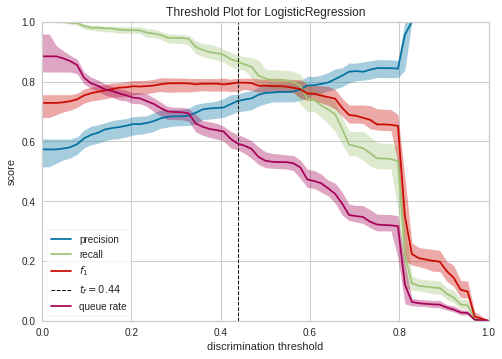

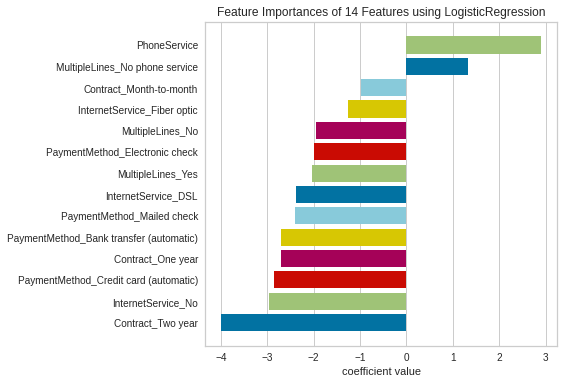

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X[rfe_cols], y, test_size = 0.3 ,random_state = 42)

log_rfe = performance(
    log_reg,
    title_text="Logistic Regression Performance",
    importance=True)

Performing the Recursive Feature Elimination slightly decreased the accuracy score and AUC score, but not much of a significant difference. However, since, the number of predictor variables have been decreased, the model is less complex.

## 5.4 Univariate Selection - Chi^2

Univariate feature selection examines each feature individually to determine the strength of the relationship of the feature with the response variable. 

In [45]:
from sklearn.feature_selection import SelectKBest, chi2

#Have to use unstandardized dataframe since chi2 does not take negative values.
cols = [i for i in df_unscaled.columns if i not in customerid + target ]

chi2_select = SelectKBest(score_func = chi2,k = 3)
chi2_fit = chi2_select.fit(df_unscaled[cols],df_unscaled.Churn)

score = pd.DataFrame({
    "features":cols,
    "scores":chi2_fit.scores_,
    "p_values":chi2_fit.pvalues_ 
})
score = score.sort_values(by = "scores" ,ascending =False)

#Label each columns as either numerical or categorical.
score["feature_type"] = np.where(score["features"].isin(num_cols),"Numerical","Categorical")
display(score)

t1 = go.Scatter(
    x = score[score["feature_type"] == "Categorical"]["features"],
    y = score[score["feature_type"] == "Categorical"]["scores"],
    name = "Categorial",mode = "lines+markers",
    marker = dict(
        color = "red",
        line = dict(width =1)
    )
)

t2 = go.Bar(
    x = score[score["feature_type"] == "Numerical"]["features"],
    y = score[score["feature_type"] == "Numerical"]["scores"],name = "Numerical",
    marker = dict(
        color = "blue",
        line = dict(width =1)
    ),
    xaxis = "x2",
    yaxis = "y2"
)

layout = go.Layout(dict(
    title = "Chi-Squared Scores",
    plot_bgcolor  = "rgb(243,243,243)",
    paper_bgcolor = "rgb(243,243,243)",
    xaxis = dict(
        gridcolor = 'rgb(255, 255, 255)',
        tickfont = dict(size =10),
        domain=[0, 0.7],
        tickangle = 90,zerolinewidth=1,
        ticklen=5,gridwidth=2),
    yaxis = dict(
        gridcolor = 'rgb(255, 255, 255)',
        title = "scores",
        zerolinewidth=1,
        ticklen=5,gridwidth=2),
    margin = dict(b=200),
    xaxis2=dict(
        domain=[0.8, 1],tickangle = 90,
        gridcolor = 'rgb(255, 255, 255)'),
    yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')
        )
)

data=[t1,t2]
fig = go.Figure(data=data,layout=layout)
fig.update_layout(title_x=0.5)
py.iplot(fig)

,features,scores,p_values,feature_type
14,TotalCharges,629630.810349,0.000000e+00,Numerical
4,tenure,16377.328093,0.000000e+00,Numerical
13,MonthlyCharges,3653.074681,0.000000e+00,Numerical
21,Contract_Month-to-month,516.714004,2.195119e-114,Categorical
23,Contract_Two year,486.223101,9.454286e-108,Categorical
26,PaymentMethod_Electronic check,424.113152,3.105849e-94,Categorical
19,InternetService_Fiber optic,372.082851,6.587130e-83,Categorical
20,InternetService_No,285.475152,4.814000e-64,Categorical
22,Contract_One year,176.608724,2.666317e-40,Categorical
6,OnlineSecurity,147.165601,7.219883e-34,Categorical


For Chi-Squared feature selection, only the desired number of variable with the best chi-squared values are selected. However, ultimately, how many and which variables to include in the model are determined by not only the results from the feature selection but also business logic. 

Another thing to note is the difference in the feature importance for the recursive feature elimination and the chi-squared. This is because each method gives a different perspective of how the variable can be useful depending on how the algorithms learn about the relationshup between y~X. 

To see the difference in performance, 10 variables with the highest score will be selected.

Accuracy Score :  0.788695652173913 

Area under curve :  0.7893736992401142 



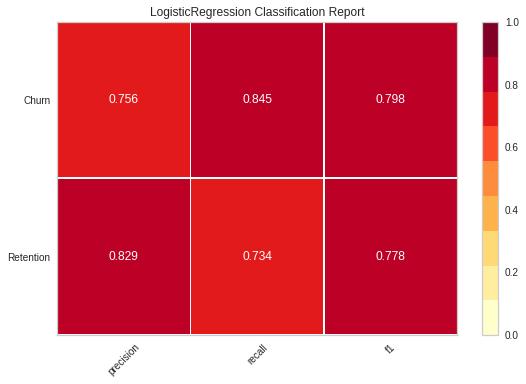

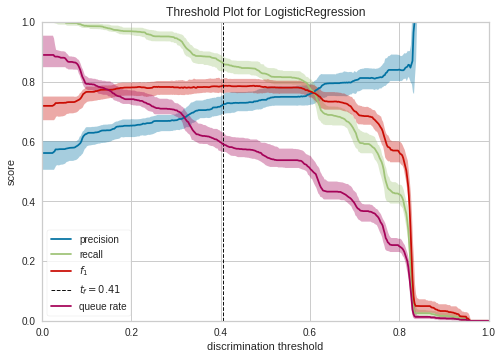

In [46]:
score_10 = score.nlargest(10,'scores')['features']
X_train, X_test, y_train, y_test = train_test_split(X[score_10], y, test_size = 0.3 ,random_state = 42)

log_chi = performance(
    log_reg,
    title_text="Logistic Regression Performance",
    importance=False)

The accuracy and AUC scores both decreased but, again, there are only slight differences. Now, which features to include is driven by business logic/decision.

## 5.5 Random Forest Classifier

Random Forest Classifier is an ensemble method (based on the divide-and-conquer approach) of decision trees generated on a randomly split dataset. This collection of decision tree classifiers is also known as the forest. The individual decision trees are generated using an attribute selection indicator such as information gain, gain ratio, and Gini index for each attribute. Each tree depends on an independent random sample. In a classification problem, each tree votes and the most popular class is chosen as the final result. It is simpler and more powerful compared to the other non-linear classification algorithms.

Accuracy Score :  0.8330434782608696 

Area under curve :  0.8334951720633077 



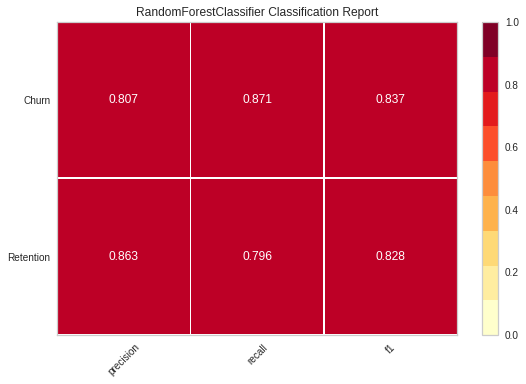

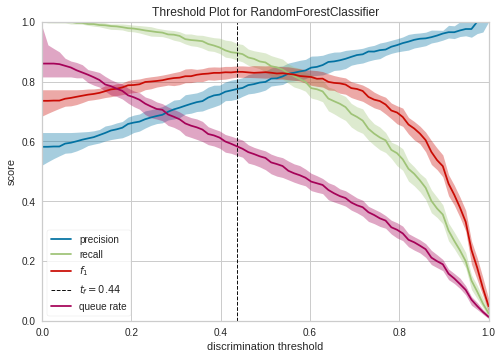

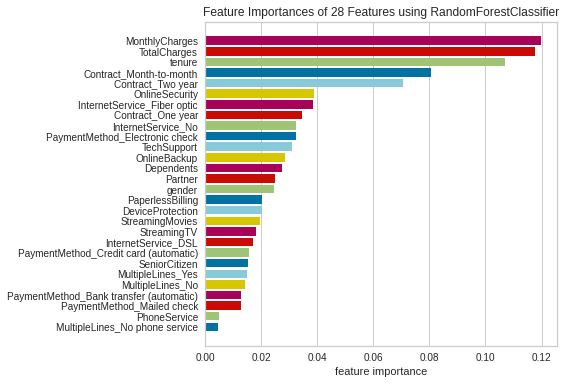

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from graphviz import Source
from IPython.display import SVG,display

cols = [i for i in df_enc.columns if i not in customerid + target ]    

rf_x = X[cols]
rf_y = y[target]

X_train, X_test, y_train, y_test = train_test_split(rf_x, rf_y, test_size = 0.3 ,random_state = 42)

rfc = RandomForestClassifier()

forest = performance(
    rfc,
    title_text="Random Forest Performance",
    importance=True
)


The Random Forest model produced a much higher accuracy and AUC score compared to any of the logistic regression models with feature elimination. The Discrimination Threshold of 0.49 is very close to 50/50 likelihood threshold. 

## 5.6 Support Vector Machine

SVM constructs a hyperplane in multidimensional space to separate different classes. SVM generates optimal hyperplane in an iterative manner, which is used to minimize an error. The core idea of SVM is to find a maximum marginal hyperplane that best divides the dataset into classes.

In [48]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV 

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3 ,random_state = 42)

clf = svm.SVC()

# Finding the optimal parameters.
param_grid = {'C': [0.1, 1, 10],  
              'gamma': [1, 0.1, 0.01], 
              'kernel': ['rbf','linear']}  
  
grid = GridSearchCV(clf, param_grid, refit = True) 
  
# Fitting the model for grid search 
grid.fit(X_train, y_train) 

print(grid.best_params_) 
print(grid.best_estimator_)


{'C': 1, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=1, gamma=1)


Accuracy Score :  0.8460869565217392 



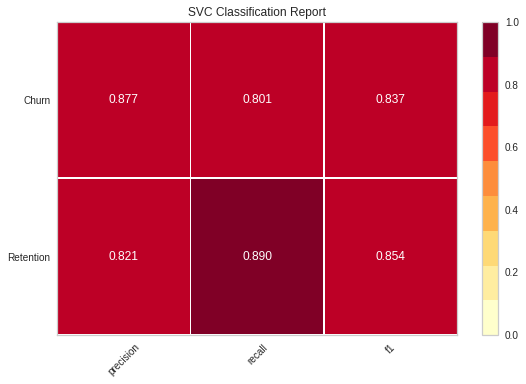

In [50]:
clf = svm.SVC(
    C=1,
    gamma=1,
    kernel='rbf'
)

clf.fit(X_train, y_train)
prediction = clf.predict(X_test)

svm_acc = accuracy_score(y_test,prediction)
print ("Accuracy Score : ", svm_acc,'\n')

report = ClassificationReport(clf, classes=['Retention','Churn'])

report.score(X_test, y_test)
c = report.poof()

conf_matrix = confusion_matrix(y_test, prediction)

t1 = go.Heatmap(
    z = conf_matrix ,
    x = ["Not churn","Churn"],
    y = ["Not churn","Churn"],
    showscale  = True,
    colorscale = "Portland",
    name = "Matrix"
)

layout = go.Layout(
    dict(
        title = 'Confusion Matrix SVM',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor = "rgb(243,243,243)",
        xaxis = dict(
            gridcolor = 'lightgrey',
            zerolinewidth=1,
            ticklen=5,
            gridwidth=2
            ),
        yaxis = dict(
            gridcolor = 'lightgrey',
            zerolinewidth=1,
            ticklen=5,
            gridwidth=2
            ),
        )
    )

data = [t1]

fig = go.Figure(data=data, layout=layout)
fig.update_layout(title_x=0.5)
py.iplot(fig)

SVM produced a higher accuracy compared to the logistics regression with or without feature elimination.

# 6. Model Accuracy Results <a class="anchor" id="accuracy"></a>

In [51]:
models = pd.DataFrame({
    'Models':[
        'Logistic Regression',
        'Logistic Regression + RFE',
        'Logistic Regression + Chi^2',
        'Random Forest Classifier',
        'Support Vector Machine'
    ],
    'Scores':[
        log, 
        log_rfe,  
        log_chi, 
        forest, 
        svm_acc, 
    ]
})

print("*** Accuracy Scores ***")
models.sort_values(by='Scores', ascending=False)

*** Accuracy Scores ***


,Models,Scores
4,Support Vector Machine,0.846087
3,Random Forest Classifier,0.833043
0,Logistic Regression,0.808261
1,Logistic Regression + RFE,0.794348
2,Logistic Regression + Chi^2,0.788696


# 7. Conclusion <a class="anchor" id="conclusion"></a>

There are various machine learning algorithms for classification problem which, in this case, is predicting the churn/retention rate of customers using Telco's telecom network services. In this predictive analysis, 3 classification algorithms were performed:

1. Logistic Regression (plus feature selection)
2. Random Forest 
3. Support Vector Machine

As shown on the model accuracy results dataframe above, support vector machine had the highest score while logistic regression with chi-squared univariate feature selection had the lowest score. Regardless of the difference in accuracy score, each algorithm comes with their own set of pros and cons. 

For example, although SVM and Random Forest provide the highest accuracy, the systematic functions of both algorithms are generally considered black boxes meaning that only the response/result is accounted for and the function/approach to how the result was produced is of little interest. After all, a forest consists of a large number of deep decision trees, where each tree is trained on bagged data using random selection of features, so gaining a full understanding of the decision process by examining each individual tree is infeasible. As for SVM, the data are transformed by kernel method to another space, which is not related to input space or, in other words, the data before and after SVM implementation are not in the same dimensionality thus cannot be compared. That is why for the SVM performance, feature importance has been excluded not by choice but due to impossibility.

On the other hand, the logistic regressions clearly had lower accuracy than the two counterpart algorithms. However, they compensate with interpretability as the model can measure how relevant a predictor is (based on the coefficient size) and its direction of association (positive or negative relationship). But then again, logistic regression assumes linearity of the data which, in the real world, is rarely the case.

Is best accuracy the goal? Is determination of feature importance the goal even though the accuracy may suffer? In the end, which method to implement into the business model, again, is determined by business logic, intuition, and goals.